Based on dataset __supermarket-sales__ from Kaggle

https://www.kaggle.com/datasets/aungpyaeap/supermarket-sales

In [1]:
%autosave 0

Autosave disabled


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
import datetime
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import mutual_info_regression
from sklearn.tree import DecisionTreeRegressor, export_text
import xgboost as xgb

# 1. Read the data

In [4]:
data = pd.read_csv('supermarket_sales.csv', parse_dates=['Date'])
print(data.shape)
data.head()

(1000, 17)


,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,10:37,Ewallet,604.17,4.761905,30.2085,5.3


# 2. EDA

In [5]:
# the data have no missing values
data.isna().sum()

Invoice ID                 0
Branch                     0
City                       0
Customer type              0
Gender                     0
Product line               0
Unit price                 0
Quantity                   0
Tax 5%                     0
Total                      0
Date                       0
Time                       0
Payment                    0
cogs                       0
gross margin percentage    0
gross income               0
Rating                     0
dtype: int64

In [6]:
# prepare the data
data.columns = data.columns.str.lower().str.replace(' ', '_')

cat_columns = data.columns[data.dtypes == 'object']
for col in cat_columns:
    data[col] = data[col].str.lower().str.replace(' ', '_')

# sort values by date
data.sort_values(by='date', inplace=True)

data.head()

,invoice_id,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5%,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating
856,770-42-8960,b,mandalay,normal,male,food_and_beverages,21.12,8,8.448,177.408,2019-01-01,19:31,cash,168.96,4.761905,8.448,6.3
567,651-88-7328,a,yangon,normal,female,fashion_accessories,65.74,9,29.583,621.243,2019-01-01,13:55,cash,591.66,4.761905,29.583,7.7
245,530-90-9855,a,yangon,member,male,home_and_lifestyle,47.59,8,19.036,399.756,2019-01-01,14:47,cash,380.72,4.761905,19.036,5.7
696,182-52-7000,a,yangon,member,female,sports_and_travel,27.04,4,5.408,113.568,2019-01-01,20:26,ewallet,108.16,4.761905,5.408,6.9
523,133-14-7229,c,naypyitaw,normal,male,health_and_beauty,62.87,2,6.287,132.027,2019-01-01,11:43,cash,125.74,4.761905,6.287,5.0


In [7]:
# show values
for col in data.columns[data.dtypes == 'object']:
    print(f'{col} {data[col].dtype} {data[col].nunique()}')
    print(data[col].unique()[:5])
    print()

invoice_id object 1000
['770-42-8960' '651-88-7328' '530-90-9855' '182-52-7000' '133-14-7229']

branch object 3
['b' 'a' 'c']

city object 3
['mandalay' 'yangon' 'naypyitaw']

customer_type object 2
['normal' 'member']

gender object 2
['male' 'female']

product_line object 6
['food_and_beverages' 'fashion_accessories' 'home_and_lifestyle'
 'sports_and_travel' 'health_and_beauty']

time object 506
['19:31' '13:55' '14:47' '20:26' '11:43']

payment object 3
['cash' 'ewallet' 'credit_card']



In [8]:
# columns branch and city are relevant
for branch in data.branch.unique():
    data_branch = data.query('branch == @branch')
    uniques_city = data_branch['city'].unique()
    print(f'branch {branch}: {uniques_city}')

branch b: ['mandalay']
branch a: ['yangon']
branch c: ['naypyitaw']


# 3. Prepare the data

__Prepare full dataframe - with all products, cities by the week__

In [9]:
# add column "week", and get aggregate data
data['week'] = data.date.dt.isocalendar().week
df_week = data.groupby(['city', 'product_line','week'], as_index=False).agg({'quantity':'sum'})
df_week.head()

,city,product_line,week,quantity
0,mandalay,electronic_accessories,1,13
1,mandalay,electronic_accessories,2,12
2,mandalay,electronic_accessories,3,19
3,mandalay,electronic_accessories,4,24
4,mandalay,electronic_accessories,5,58


In [10]:
products = df_week.product_line.unique()
products

array(['electronic_accessories', 'fashion_accessories',
       'food_and_beverages', 'health_and_beauty', 'home_and_lifestyle',
       'sports_and_travel'], dtype=object)

In [11]:
cities = df_week.city.unique()
cities

array(['mandalay', 'naypyitaw', 'yangon'], dtype=object)

In [12]:
print('week min:',df_week.week.min())
print('week max:',df_week.week.max())

week min: 1
week max: 13


In [13]:
weeks = range(1,14)

In [14]:
# get the full dataframe with all sales by the product_line and city in each week
df_full = pd.DataFrame(itertools.product(products, cities, weeks), columns=['product_line', 'city', 'week'])
df_full = df_full.merge(df_week, how='left', on=['product_line', 'city','week'])
print(df_full.shape)
df_full.head()

(234, 4)


,product_line,city,week,quantity
0,electronic_accessories,mandalay,1,13.0
1,electronic_accessories,mandalay,2,12.0
2,electronic_accessories,mandalay,3,19.0
3,electronic_accessories,mandalay,4,24.0
4,electronic_accessories,mandalay,5,58.0


In [15]:
# data contain rows without sales
df_full.isna().sum()

product_line    0
city            0
week            0
quantity        6
dtype: int64

In [16]:
df_full.fillna(0, inplace=True)

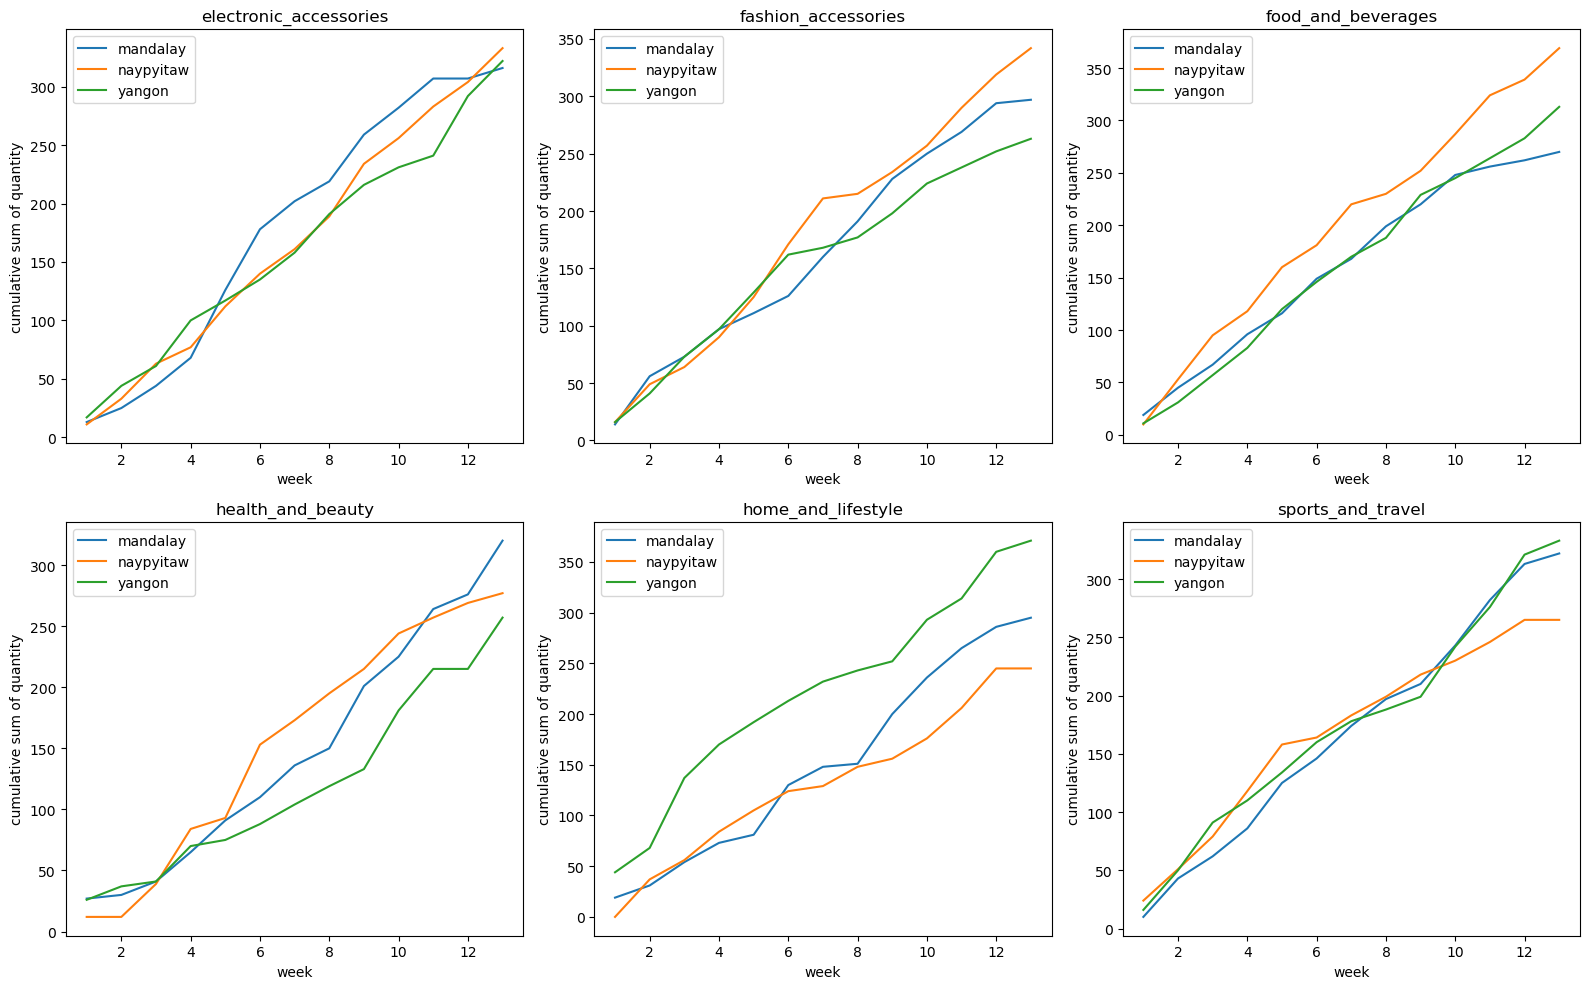

In [17]:
# Let's take a look at the sales by the products and the city (target value)
fig, axes = plt.subplots(2,3, figsize=(16,10))
for i, ax in enumerate(axes.reshape(-1)):
    product = products[i]
    
    for city in cities:
        df = df_full.query('product_line == @product & city == @city')
        ax.plot(df.week, df.quantity.cumsum(), label=city)
    
    #ax.tick_params(axis='x', rotation=-45)
    ax.set_xlabel('week')
    ax.set_ylabel('cumulative sum of quantity')
    ax.set_title(product)
    ax.legend()
    
plt.tight_layout()

In [18]:
def get_df_lags(df, lags=[1,2,3]):
    """
    add lags to dataframe
    return new dataframe
    """
    
    df_lag = df.copy()
    
    for lag in lags:
        df_lag[f'lag_{lag}'] = df_lag.quantity.shift(lag)
            
    return df_lag

In [19]:
lags = [1,2,3,4,5,6]
df_full_lags = get_df_lags(df_full, lags).dropna()
print(df_full_lags.shape)
df_full_lags.head()

(228, 10)


,product_line,city,week,quantity,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
6,electronic_accessories,mandalay,7,24.0,52.0,58.0,24.0,19.0,12.0,13.0
7,electronic_accessories,mandalay,8,17.0,24.0,52.0,58.0,24.0,19.0,12.0
8,electronic_accessories,mandalay,9,40.0,17.0,24.0,52.0,58.0,24.0,19.0
9,electronic_accessories,mandalay,10,23.0,40.0,17.0,24.0,52.0,58.0,24.0
10,electronic_accessories,mandalay,11,25.0,23.0,40.0,17.0,24.0,52.0,58.0


# 4. Feature importances

In [20]:
cat_columns = ['product_line', 'city']
num_columns = list(df_full_lags.columns[df_full_lags.columns.str.startswith('lag')])
num_columns

['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6']

In [21]:
X = df_full_lags[cat_columns+num_columns].copy()
y = df_full_lags['quantity']

for col in cat_columns:
    X[col], _ = X[col].factorize()

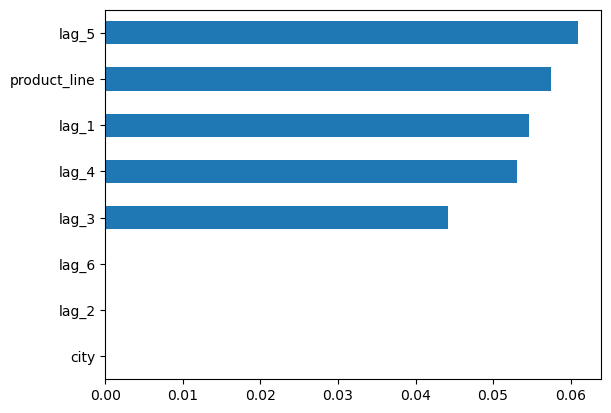

In [22]:
mi_scores = pd.Series(mutual_info_regression(X, y), index=X.columns)
mi_scores.sort_values().plot(kind='barh');

In [23]:
# based on feature importances above - remove columns lag_2 and lag_6
del df_full_lags['lag_2']
del df_full_lags['lag_6']

# 5. Split the data

In [24]:
df_train = df_full_lags[df_full_lags['week'] < 12]
df_val = df_full_lags[df_full_lags['week'] == 12]
df_test = df_full_lags[df_full_lags['week'] == 13]
len(df_train), len(df_val), len(df_test)

(192, 18, 18)

# 6. Simple model (without ML)

Sales in the next week is equal of sales by the current week

In [25]:
X_train = df_full.query("week == 11")[['product_line','city','quantity']].copy()
X_val = df_full.query("week == 12")[['product_line','city','quantity']].copy()
X_pred = X_train.merge(X_val, how='left', on=['city', 'product_line'], suffixes=['_true', '_pred'])
X_pred['error'] = X_pred['quantity_true'] - X_pred['quantity_pred']
X_pred

,product_line,city,quantity_true,quantity_pred,error
0,electronic_accessories,mandalay,25.0,0.0,25.0
1,electronic_accessories,naypyitaw,27.0,21.0,6.0
2,electronic_accessories,yangon,10.0,51.0,-41.0
3,fashion_accessories,mandalay,19.0,25.0,-6.0
4,fashion_accessories,naypyitaw,33.0,29.0,4.0
5,fashion_accessories,yangon,14.0,14.0,0.0
6,food_and_beverages,mandalay,8.0,6.0,2.0
7,food_and_beverages,naypyitaw,37.0,15.0,22.0
8,food_and_beverages,yangon,19.0,19.0,0.0
9,health_and_beauty,mandalay,39.0,12.0,27.0


In [26]:
# evaluate naive model
mean_absolute_error(X_pred['quantity_true'], X_pred['quantity_pred'])

12.88888888888889

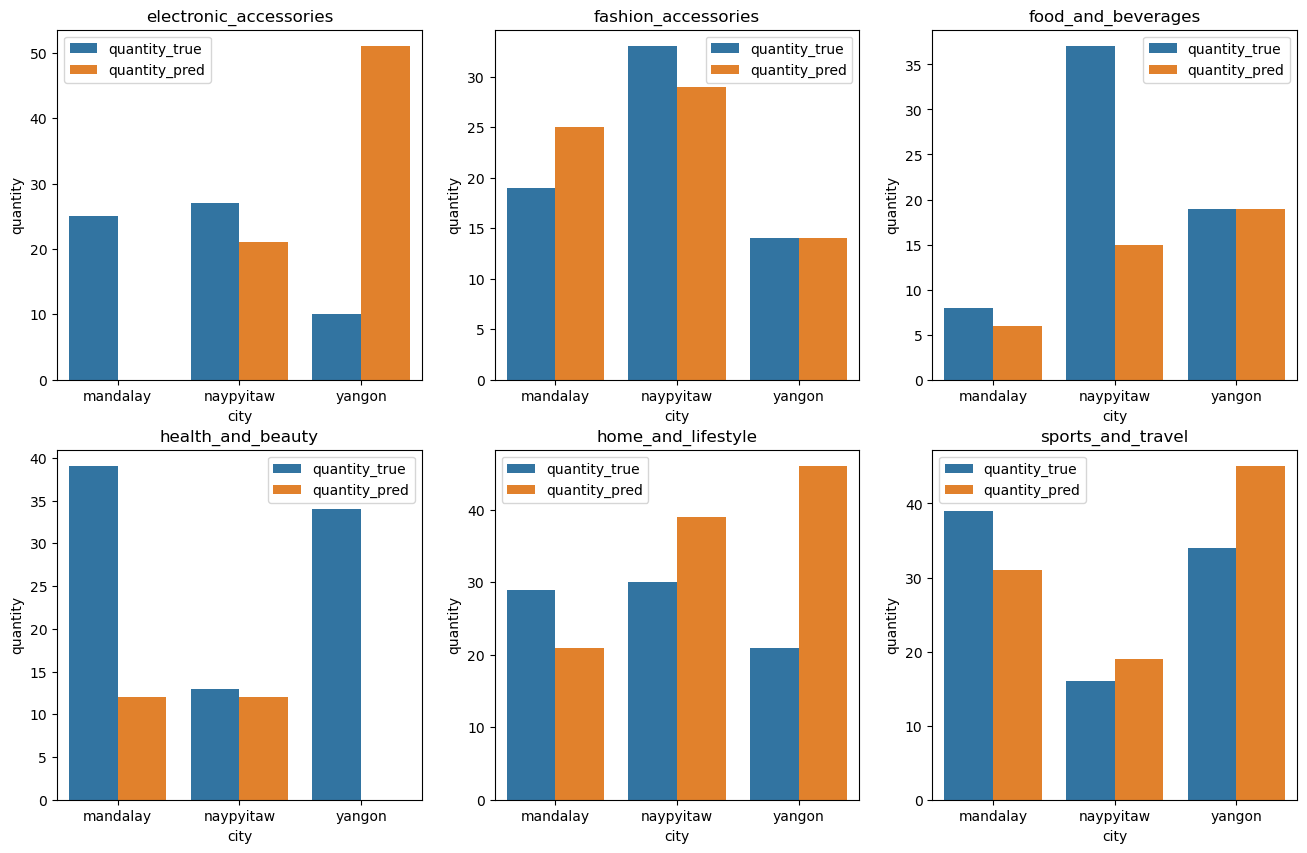

In [27]:
fig, axes = plt.subplots(2,3, figsize=(16,10))
for i, ax in enumerate(axes.reshape(-1)):
    product = products[i]
    df = X_pred.query('product_line == @product').melt(id_vars='city', 
                                                        value_vars=['quantity_true', 'quantity_pred'],
                                                        var_name='target',
                                                        value_name='quantity')
    sns.barplot(data=df, x='city', y='quantity', hue='target', ax=ax)
    ax.set_title(product)
    ax.legend()

# 7. Train models

In [28]:
columns = ['product_line', 'city'] + list(df_full_lags.columns[df_full_lags.columns.str.startswith('lag')])
columns

['product_line', 'city', 'lag_1', 'lag_3', 'lag_4', 'lag_5']

In [29]:
dv = DictVectorizer(sparse=False)
train_dicts = df_train[columns].to_dict(orient='records')
val_dicts = df_val[columns].to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)
y_train = df_train['quantity'].values

X_val = dv.transform(val_dicts)
y_val = df_val['quantity'].values

### 7.1 Linear regression

In [30]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
mean_absolute_error(y_val, y_pred)

12.742722625706437

### 7.2 Decision tree

In [31]:
dt = DecisionTreeRegressor(max_depth=2)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_val)
mean_absolute_error(y_val, y_pred)

15.21701388888889

In [32]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- lag_4 <= 18.50
|   |--- lag_3 <= 13.50
|   |   |--- value: [21.50]
|   |--- lag_3 >  13.50
|   |   |--- value: [30.00]
|--- lag_4 >  18.50
|   |--- lag_3 <= 1.50
|   |   |--- value: [36.00]
|   |--- lag_3 >  1.50
|   |   |--- value: [22.09]



### 7.3 Random fores

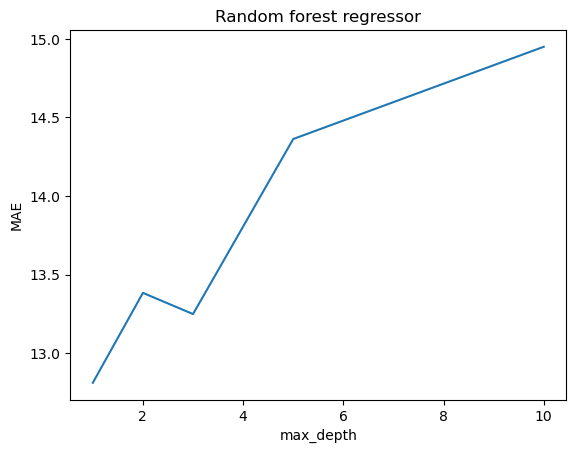

In [33]:
scores = []
max_depths = [1,2,3,5,10]
for max_depth in max_depths:
    rf = RandomForestRegressor(n_estimators=10, max_depth=max_depth, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    scores.append(mean_absolute_error(y_val, y_pred))
plt.title("Random forest regressor")
plt.xlabel('max_depth')
plt.ylabel('MAE')
plt.plot(max_depths, scores);

In [34]:
# fit random forest with best params
rf = RandomForestRegressor(n_estimators=10, max_depth=1, random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val).round()
mean_absolute_error(y_val, y_pred)

12.666666666666666

### 7.4 XGBoost

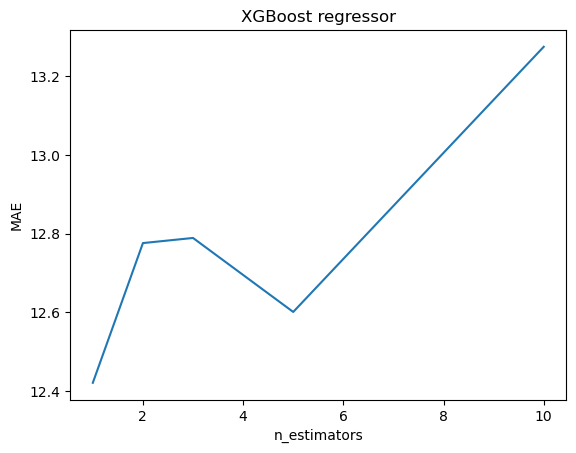

In [35]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

xgb_params = {
    'eval_metric': 'mae',
    'max_depth': 3,
    'eta':0.1,
    'nthread': 8,  
    'seed': 1,
    'verbosity': 1,
}

scores = []
max_depths = [1,2,3,5,10]

for max_depth in max_depths:
    xgb_params['max_depth'] = max_depth
    
    model = xgb.train(xgb_params, dtrain)
    y_pred = model.predict(dval)
    scores.append(mean_absolute_error(y_val, y_pred))
    
plt.title("XGBoost regressor")
plt.xlabel('n_estimators')
plt.ylabel('MAE')
plt.plot(max_depths, scores);    

In [36]:
# fit xgb with best params
xgb_params_best = {
    'eval_metric': 'mae',
    'max_depth': 1,
    'eta':0.1,
    'nthread': 8,  
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params_best, dtrain, evals=[(dtrain,'train'),(dval,'val')])
y_pred = model.predict(dval).round()
mean_absolute_error(y_val, y_pred)

[0]	train-mae:21.28269	val-mae:20.23053
[1]	train-mae:19.27336	val-mae:18.56035
[2]	train-mae:17.54165	val-mae:17.09369
[3]	train-mae:16.01648	val-mae:15.88871
[4]	train-mae:14.71204	val-mae:14.82971
[5]	train-mae:13.63617	val-mae:13.92764
[6]	train-mae:12.73171	val-mae:13.25264
[7]	train-mae:11.98367	val-mae:12.88427
[8]	train-mae:11.37869	val-mae:12.62463
[9]	train-mae:10.86175	val-mae:12.42098


12.333333333333334

In [37]:
X_pred = df_val.copy()
X_pred['quantity_pred'] = y_pred
X_pred

,product_line,city,week,quantity,lag_1,lag_3,lag_4,lag_5,quantity_pred
11,electronic_accessories,mandalay,12,0.0,25.0,40.0,17.0,24.0,17.0
24,electronic_accessories,naypyitaw,12,21.0,27.0,45.0,28.0,21.0,16.0
37,electronic_accessories,yangon,12,51.0,10.0,25.0,33.0,23.0,16.0
50,fashion_accessories,mandalay,12,25.0,19.0,37.0,31.0,34.0,15.0
63,fashion_accessories,naypyitaw,12,29.0,33.0,19.0,4.0,40.0,17.0
76,fashion_accessories,yangon,12,14.0,14.0,21.0,9.0,6.0,18.0
89,food_and_beverages,mandalay,12,6.0,8.0,21.0,31.0,19.0,16.0
102,food_and_beverages,naypyitaw,12,15.0,37.0,22.0,10.0,39.0,17.0
115,food_and_beverages,yangon,12,19.0,19.0,41.0,18.0,24.0,17.0
128,health_and_beauty,mandalay,12,12.0,39.0,51.0,14.0,26.0,17.0


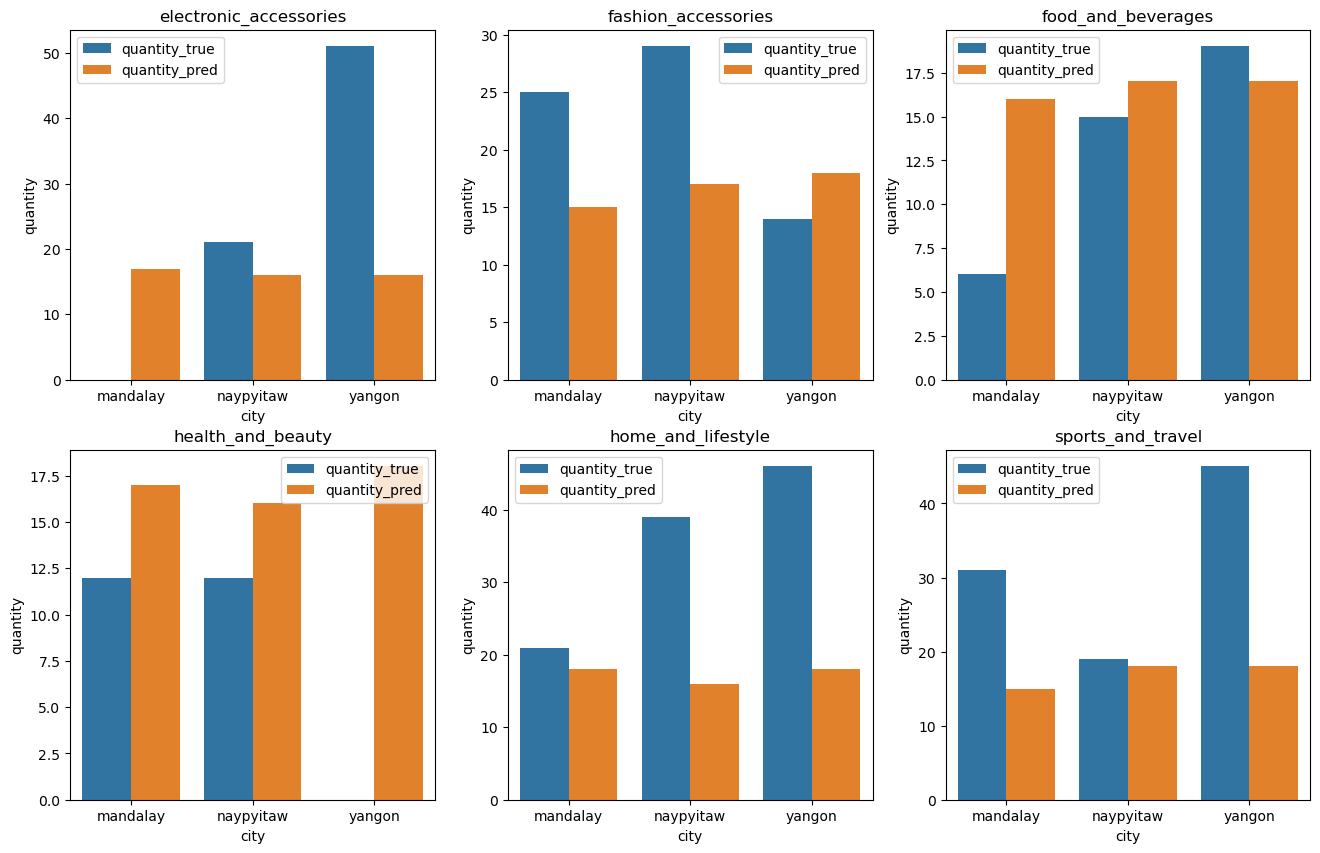

In [38]:
fig, axes = plt.subplots(2,3, figsize=(16,10))
for i, ax in enumerate(axes.reshape(-1)):
    product = products[i]
    df = X_pred.query('product_line == @product')[['product_line', 'city','quantity','quantity_pred']].copy()
    df.columns = ['product_line', 'city','quantity_true','quantity_pred'] 
    df = df.melt(id_vars='city', 
                 value_vars=['quantity_true', 'quantity_pred'],
                 var_name='target',
                 value_name='quantity')
    sns.barplot(data=df, x='city', y='quantity', hue='target', ax=ax)
    ax.set_title(product)
    ax.legend()

# 8. Final model

In [39]:
df_train = df_full_lags.query('week < 13')
df_test = df_full_lags.query('week == 13')

In [40]:
dv = DictVectorizer(sparse=False)
train_dicts = df_train[columns].to_dict(orient='records')
test_dicts = df_test[columns].to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)
y_train = df_train['quantity'].values

X_test = dv.transform(test_dicts)
y_test = df_test['quantity'].values

In [41]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

In [42]:
xgb_params_best = {
    'eval_metric': 'mae',
    'max_depth': 1,
    'eta':0.1,
    'nthread': 8,  
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params_best, dtrain)
y_pred = model.predict(dtest).round()
mean_absolute_error(y_val, y_pred)

12.0

In [43]:
X_pred = df_test.copy()
X_pred['quantity_pred'] = y_pred
X_pred

,product_line,city,week,quantity,lag_1,lag_3,lag_4,lag_5,quantity_pred
12,electronic_accessories,mandalay,13,9.0,0.0,23.0,40.0,17.0,16.0
25,electronic_accessories,naypyitaw,13,29.0,21.0,22.0,45.0,28.0,15.0
38,electronic_accessories,yangon,13,30.0,51.0,15.0,25.0,33.0,15.0
51,fashion_accessories,mandalay,13,3.0,25.0,22.0,37.0,31.0,15.0
64,fashion_accessories,naypyitaw,13,23.0,29.0,23.0,19.0,4.0,16.0
77,fashion_accessories,yangon,13,11.0,14.0,26.0,21.0,9.0,16.0
90,food_and_beverages,mandalay,13,8.0,6.0,28.0,21.0,31.0,15.0
103,food_and_beverages,naypyitaw,13,30.0,15.0,35.0,22.0,10.0,16.0
116,food_and_beverages,yangon,13,30.0,19.0,16.0,41.0,18.0,16.0
129,health_and_beauty,mandalay,13,44.0,12.0,24.0,51.0,14.0,15.0


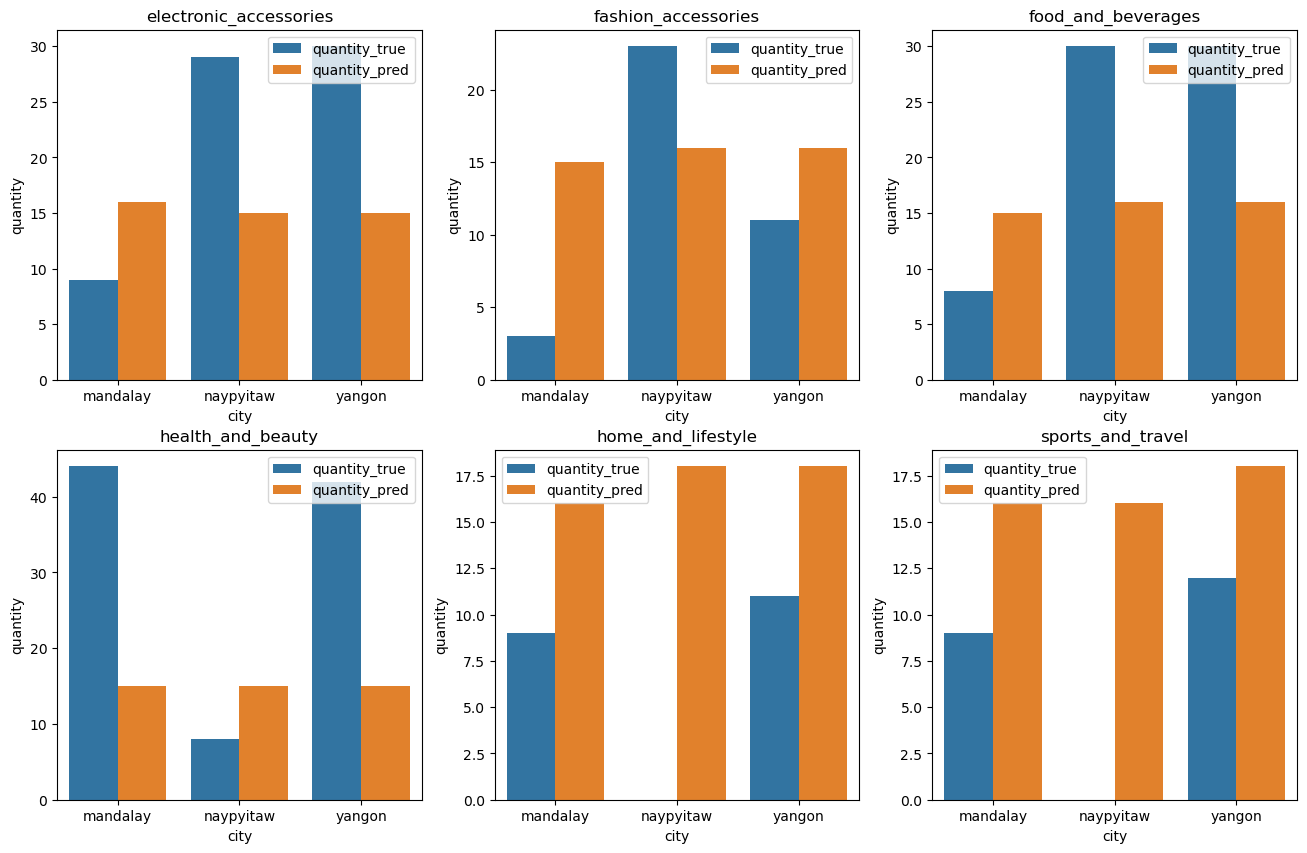

In [44]:
fig, axes = plt.subplots(2,3, figsize=(16,10))
for i, ax in enumerate(axes.reshape(-1)):
    product = products[i]
    df = X_pred.query('product_line == @product')[['product_line', 'city','quantity','quantity_pred']].copy()
    df.columns = ['product_line', 'city','quantity_true','quantity_pred'] 
    df = df.melt(id_vars='city', 
                 value_vars=['quantity_true', 'quantity_pred'],
                 var_name='target',
                 value_name='quantity')
    sns.barplot(data=df, x='city', y='quantity', hue='target', ax=ax)
    ax.set_title(product)
    ax.legend()